# Ejercicio 1
Implemente las estructuras de datos y algoritmos básicos para la solución de un problema mediante algoritmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de las siguientes funciones:

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import math
import string
import random
%matplotlib widget

In [111]:
def bin2dec(b):
    # compongo el número teniendo en cuenta que el primer
    # bit es para el signo y que los 4 últimos son la parte decimal
    d = int(b[1:-4], 2) + 0.1 * int(b[-4:], 2)
    
    if b[0] == '1':
        # si hay un 1 delante, es negativo
        return -d
    else:
        # si hay un 0 delante, es positivo
        return d

def decode(pob):
    pob_real = []
    for i in range(len(pob)):
        pob_real.append(bin2dec(pob[i]))
    return pob_real

def initialize(n_ind, bits, f):
    # n_ind: cantidad de individuos
    # bits: cantidad de bits para el entero
    poblation = []
    for i in range(n_ind):
        poblation.append(f(bits))
    return poblation

def pob_evaluation(p, f, f_max = 0):
    pob_fitness = []
    mejor_pos = 0
    for ind in p:
        # el fitness se evalúa como 1 / f(x) + f_max ya que buscamos el máximo fitness para el mínimo de una función
        f_actual = 1 / (f(ind) + f_max)
        pob_fitness.append(f_actual)
    return pob_fitness

def roullete_wheel_selection(p_fitness, p):
    p_sum = sum(p_fitness)
    selection_probs = [f/p_sum for f in p_fitness]
    return np.random.choice(len(p), p = selection_probs)

def cruza(pob, punto_cruza, prob_cruza):
    # inicializo la nueva población
    prox_pob = []
    # repito n_ind/2 veces elección de 2 padres y realización de la cruza (o no)
    n_cruzas = int(len(pob)/2)
    for i in range(n_cruzas):
        padre = pob[2 * i]
        madre = pob[2 * i + 1]
        # elijo un rand entre 0 y 1
        c_cruza = np.random.rand()
        if c_cruza < prob_cruza:
            # se realiza la cruza: tomo desde el punto de cruza hasta la cantidad de bits
            # que considero para la parte entera
            hijo1 = padre[0 : punto_cruza] + madre[punto_cruza:]
            hijo2 = madre[0 : punto_cruza] + padre[punto_cruza:]
            # print(f'padre: {pob[i]} - madre: {pob[i+1]} - hijo1: {hijo1} - hijo 2: {hijo2}')
            prox_pob.append(hijo1)
            prox_pob.append(hijo2)
            # print('se hizo la cruza')
        else:
            # se mantienen los padres en la nueva población
            prox_pob.append(padre)
            prox_pob.append(madre)
            # print('no se hizo la cruza')
    return prox_pob

def mutacion(prox_pob, prob_mutacion, n_bits_int):
    for i, ind in enumerate(prox_pob):
        # elijo un rand entre 0 y 1
        c_mutacion = np.random.rand()
        # print('cromosoma sin mutar', ind)
        if c_mutacion < prob_mutacion:
            # se realiza la mutación teniendo en cuenta que se hace en los bits de los enteros
            pos_mutacion = 1 + np.random.choice(n_bits_int)
            l_ind = list(ind)
            if l_ind[pos_mutacion] == '0':
                l_ind[pos_mutacion] = '1'
            else:
                l_ind[pos_mutacion] = '0'
            ind = ''.join(l_ind)
            # print('cromosoma mutado', ind)
        prox_pob[i] = ind
    return prox_pob

## Funcion 1

1. $ f(x) = - x \sin(\sqrt{|x|}) $, con $ x \in [-512...512] $

Podemos considerar la codificación de un número decimal entre -512 y 512 teniendo en cuenta reales con un cromosoma de 14 genes, de la siguiente manera:

1 bit para el signo (0 para negativos, 1 para positivos)

9 bits para representar los enteros

4 bits para representar los decimales

In [112]:
def generate_bin_f1(n_bits):
    # n_bits = cantidad de bits para la parte entera considerando 1 para el signo

    # elijo al azar una cadena de digitos en [0,1] para generar los cromosomas aleatorios
    source = string.digits[:2]
    chrom = ''.join((random.choice(source) for i in range(n_bits + 4)))
    for s in chrom:
        # si los bits designados para la parte decimal (4) son mayores que 9 se consideran 9
        if int(chrom[-4:],2) > 9:
            chrom = chrom[:-4] + '1001'
    return chrom
    
def func_1 (x):
    f_x = - x * np.sin(np.sqrt(abs(x)))
    return f_x

([<matplotlib.lines.Line2D at 0x2b2d9401120>],
 Text(0.5, 1.0, 'función de fitness'))

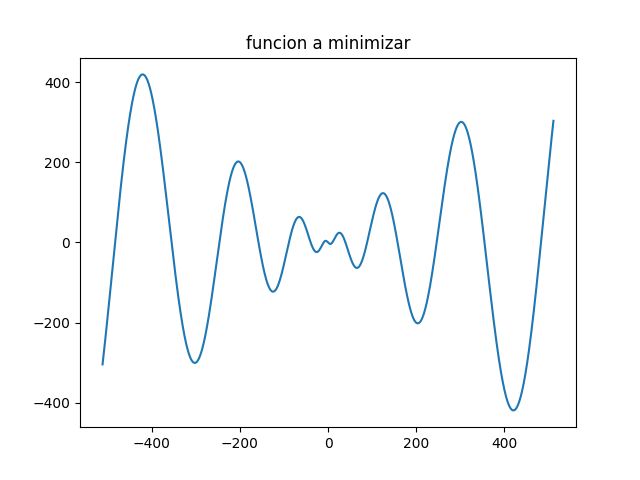

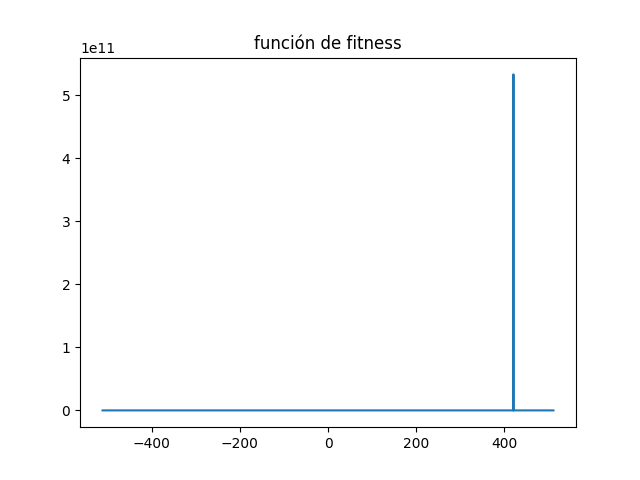

In [113]:
# Funcion a maximizar 

plt.close('all')
x = np.arange(-512, 512, 0.1)
plt.figure()
plt.plot(x, func_1(x)), plt.title('funcion a minimizar')
a = np.max(func_1(x)) # uso esto para hacer que la f de fitness de valores positivos

plt.figure()
plt.plot(x, 1 / (func_1(x)  + a)), plt.title('función de fitness')

### Resolución

In [114]:
print('Mínimo a encontrar: ', x[np.argmin(func_1(x))], np.min(func_1(x)))

# inicializo la población
n_ind = 100                         # cantidad de individuos
n_bits = 10                        # cantidad de bits para la parte entera

# criterios de finalización
fitness_th = 10                     # fitness buscado
gen_max = 5000                      # cantidad maxima de generaciones
n_estab = 25                        # cantidad de iteraciones para considerar una solución estable

# otros parámetros
prob_cruza = 0.8                    # probabilidad de cruza
prob_mutacion = 0.1                 # probabilidad de mutación
punto_cruza = int(0.7 * n_bits)     # a partir de donde cruzo

# Inicialización
pob = initialize(n_ind, n_bits, generate_bin_f1)

# decodificación a reales para poder evaluar la f de fitness
pob_real = decode(pob)

# evaluación inicial
# positivizo la función sumandole el máximo a los valores
max_f = a
pob_fitness = pob_evaluation(pob_real, func_1, max_f)
fitness_best_ind = np.max(pob_fitness)
# print('fitness máximo de la generación 0', fitness_best_ind)

n_gen = 0
c_estabilidad = 0
while(n_gen < gen_max - 1 and c_estabilidad < n_estab):
    # Selección de padres: elijo n_ind padres con el metodo elegido
    prog_idx = []
    for i in range (n_ind):
        prog_idx.append(roullete_wheel_selection(pob_fitness, pob_real))
    
    # Cruza
    prox_pob = cruza(pob, punto_cruza, prob_cruza)

    # Mutación
    prox_pob = mutacion(prox_pob, prob_mutacion, n_bits)

    # Se evalúa la nueva población
    pob = prox_pob
    # decodificación a reales para poder evaluar la f de fitness
    
    pob_real = decode(pob)
    pob_fitness = pob_evaluation(pob_real, func_1, a)
    # busco el mejor individuo de la población
    fitness_best_ind_ = fitness_best_ind
    fitness_best_ind = np.max(pob_fitness)
    if np.isclose(fitness_best_ind, fitness_best_ind_):
        # si el anterior mejor fitness está cerca del nuevo, aumento el contador
        c_estabilidad += 1
    else:
        c_estabilidad = 0
    # print(f'fitness máximo de la generación {n_gen + 1}: {fitness_best_ind}')
    n_gen += 1

print(f'finalizó en la generación {n_gen+1}')
print(f'mínimo encontrado en la generación {n_gen+1}: {pob_real[np.argmax(pob_fitness)], 1 / np.max(pob_fitness) - a}')


Mínimo a encontrar:  421.00000000021214 -418.9827640161426
finalizó en la generación 5000
mínimo encontrado en la generación 5000: (421.0, -418.9827640161443)


## Funcion 2
2. $ f(x) = x + 5 \sin(3x) + 8 \cos (5 x)$, con $x \in \mathbb R $ en el intervalo $[0...20]$

1 bit para el signo (siempre es 0)

5 bits para la parte entera

4 bits para el decimal


In [102]:
def func_2 (x):
    f_x = x + 5 * np.sin(3 * x) + 8 * np.cos(5 * x)
    return f_x

In [107]:
def generate_bin_f2(n_bits):
    # n_bits = cantidad de bits para la parte entera considerando 1 para el signo

    # elijo al azar una cadena de digitos en [0,1] para generar los cromosomas aleatorios
    source = string.digits[:2]
    chrom = ''.join((random.choice(source) for i in range(n_bits - 1 + 4)))
    for s in chrom:
        # si los bits designados para la parte decimal (4) son mayores que 9 se consideran 9
        if int(chrom[-4:],2) > 9:
            chrom = chrom[:-4] + '1001'

    # en este caso siempre el primer bit es 0
    chrom = '0' + chrom
    return chrom


print('Mínimo a encontrar: ', x[np.argmin(func_2(x))], np.min(func_2(x)))

# inicializo la población
n_ind = 30                         # cantidad de individuos
n_bits = 6                         # cantidad de bits para la parte entera (con el signo)

# criterios de finalización
fitness_th = 10                     # fitness buscado
gen_max = 5000                      # cantidad maxima de generaciones
n_estab = 25                        # cantidad de iteraciones para considerar una solución estable

# otros parámetros
prob_cruza = 0.8                    # probabilidad de cruza
prob_mutacion = 0.1                 # probabilidad de mutación
punto_cruza = int(0.7 * n_bits)     # a partir de donde cruzo

# Inicialización
pob = initialize(n_ind, n_bits, generate_bin_f2)

# decodificación a reales para poder evaluar la f de fitness
pob_real = decode(pob)

# evaluación inicial
# positivizo la función sumandole el máximo a los valores
max_f = a
pob_fitness = pob_evaluation(pob_real, func_2, max_f)
fitness_best_ind = np.max(pob_fitness)
# print('fitness máximo de la generación 0', fitness_best_ind)

n_gen = 0
c_estabilidad = 0
while(n_gen < gen_max - 1 and c_estabilidad < n_estab):
    # Selección de padres: elijo n_ind padres con el metodo elegido
    prog_idx = []
    for i in range (n_ind):
        prog_idx.append(roullete_wheel_selection(pob_fitness, pob_real))
    
    # Cruza
    prox_pob = cruza(pob, punto_cruza, prob_cruza)

    # Mutación
    prox_pob = mutacion(prox_pob, prob_mutacion, n_bits)

    # Se evalúa la nueva población
    pob = prox_pob
    # decodificación a reales para poder evaluar la f de fitness
    
    pob_real = decode(pob)
    pob_fitness = pob_evaluation(pob_real, func_2, a)
    # busco el mejor individuo de la población
    fitness_best_ind_ = fitness_best_ind
    fitness_best_ind = np.max(pob_fitness)
    if np.isclose(fitness_best_ind, fitness_best_ind_):
        # si el anterior mejor fitness está cerca del nuevo, aumento el contador
        c_estabilidad += 1
    else:
        c_estabilidad = 0
    # print(f'fitness máximo de la generación {n_gen + 1}: {fitness_best_ind}')
    n_gen += 1

print(f'finalizó en la generación {n_gen+1}')
print(f'mínimo encontrado en la generación {n_gen+1}: {pob_real[np.argmax(pob_fitness)], 1 / np.max(pob_fitness) - a}')

Mínimo a encontrar:  1.8 -9.352864532857351
finalizó en la generación 1495
mínimo encontrado en la generación 1495: (1.9, -8.83080496255922)


## Funcion 3
3. $ f(x, y) = (x^2 + y^2)^{0.25} [\sin^2 (50 (x^2 + y^2)^{0.1}) + 1]$, con $x, y \in [-100...100]$